# Part 2: Initial Portfolio Construction

**Objective**: Build and analyze an equal-weight portfolio from S&P 500 stocks.

**Key Tasks**:
1. Load preprocessed data from Part 1
2. Build equal-weight portfolio (w_i = 1/n = 1/100)
3. Compute daily portfolio returns: r_p,t = Σ(w_i × r_i,t)
4. Simulate portfolio value evolution over time
5. Analyze performance metrics and visualizations

**Deliverables**:
- Daily portfolio returns time series
- Portfolio value evolution from $100,000 initial investment
- Performance metrics (CAGR, Sharpe ratio, maximum drawdown)
- Comprehensive visualizations and analysis

In [26]:
# Part 2: Initial Portfolio Construction
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("📦 Libraries imported successfully!")
print("🎯 Ready for portfolio construction")

📦 Libraries imported successfully!
🎯 Ready for portfolio construction


## Load Data from Part 1

First, we need to load the preprocessed data from Part 1: Data Acquisition & Preprocessing.

In [27]:
# Load preprocessed data from Part 1
print("📂 Loading preprocessed data...")

# Check if data files exist from Part 1
data_dir = Path("../Part 1: Data Acquisition & Preprocessing")
prices_file = data_dir / "sp500_prices_5yr.csv"
returns_file = data_dir / "sp500_log_returns_5yr.csv"
tickers_file = data_dir / "sp500_tickers_top100.txt"

print("✅ Found saved data files from Part 1")

# Load prices
prices = pd.read_csv(prices_file, index_col=0, parse_dates=True)
print(f"📈 Loaded prices: {prices.shape}")

# Load log returns
log_returns = pd.read_csv(returns_file, index_col=0, parse_dates=True)
print(f"📊 Loaded log returns: {log_returns.shape}")

# Load tickers
if tickers_file.exists():
    with open(tickers_file, 'r') as f:
        tickers = [line.strip() for line in f.readlines()]
    print(f"🎯 Loaded {len(tickers)} tickers")
else:
    tickers = list(prices.columns)
    print(f"🎯 Using {len(tickers)} tickers from price data")

# Data validation
print(f"\n🔍 Data Validation:")
print(f"Prices shape: {prices.shape}")
print(f"Returns shape: {log_returns.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")
print(f"Number of tickers: {len(tickers)}")

# Display sample data
print(f"\n📋 Sample Prices (first 5 rows, first 5 columns):")
print(prices.iloc[:5, :5])

print(f"\n📋 Sample Log Returns (first 5 rows, first 5 columns):")
print(log_returns.iloc[:5, :5])

📂 Loading preprocessed data...
✅ Found saved data files from Part 1
📈 Loaded prices: (1254, 100)
📊 Loaded log returns: (1253, 100)
🎯 Loaded 100 tickers

🔍 Data Validation:
Prices shape: (1254, 100)
Returns shape: (1253, 100)
Date range: 2020-08-07 00:00:00 to 2025-08-05 00:00:00
Number of tickers: 100

📋 Sample Prices (first 5 rows, first 5 columns):
                  AAPL       GOOG      GOOGL        AMZN       AVGO
2020-08-07  108.203781  74.282951  74.471870  158.373001  28.915098
2020-08-10  109.776497  74.362968  74.394821  157.408005  29.041964
2020-08-11  106.511749  73.578644  73.585678  154.033493  28.746536
2020-08-12  110.051590  74.885872  74.912720  158.112000  29.599102
2020-08-13  111.999237  75.473869  75.380417  158.050995  29.224718

📋 Sample Log Returns (first 5 rows, first 5 columns):
                AAPL      GOOG     GOOGL      AMZN      AVGO
2020-08-10  0.014430  0.001077 -0.001035 -0.006112  0.004378
2020-08-11 -0.030191 -0.010603 -0.010936 -0.021671 -0.010225
2

## Step 1: Build Equal-Weight Portfolio

Create an equal-weight portfolio where each stock has the same weight: w_i = 1/n = 1/100.

In [28]:
# Build equal-weight portfolio
print("⚖️ Building equal-weight portfolio...")

# Get the number of stocks in our universe
n_stocks = len(tickers)
print(f"📊 Number of stocks: {n_stocks}")

# Calculate equal weights: w_i = 1/n
equal_weight = 1.0 / n_stocks
weights = pd.Series(equal_weight, index=tickers, name='Weight')

print(f"🎯 Equal weight per stock: {equal_weight:.4f} " +
      f"({equal_weight*100:.2f}%)")

# Verify weights sum to 1
total_weight = weights.sum()
print(f"✅ Total weight verification: {total_weight:.6f} " +
      "(should be 1.0)")

# Display weights information
print(f"\n📋 Portfolio Weights Summary:")
print(f"Each stock weight: {equal_weight:.6f}")
print(f"Total stocks: {n_stocks}")
print(f"Sum of weights: {total_weight:.6f}")

# Display sample weights
print(f"\n📊 Sample weights (first 10 stocks):")
print(weights.head(10))

# Create weights DataFrame for easier handling
weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Weight': equal_weight
})

print(f"🎯 Equal-weight portfolio constructed successfully!")
print(f"Portfolio composition: {n_stocks} stocks, each with " +
      f"{equal_weight*100:.4f}% allocation")

⚖️ Building equal-weight portfolio...
📊 Number of stocks: 100
🎯 Equal weight per stock: 0.0100 (1.00%)
✅ Total weight verification: 1.000000 (should be 1.0)

📋 Portfolio Weights Summary:
Each stock weight: 0.010000
Total stocks: 100
Sum of weights: 1.000000

📊 Sample weights (first 10 stocks):
AAPL     0.01
GOOG     0.01
GOOGL    0.01
AMZN     0.01
AVGO     0.01
BRK-B    0.01
COST     0.01
ABBV     0.01
BAC      0.01
CVX      0.01
Name: Weight, dtype: float64
🎯 Equal-weight portfolio constructed successfully!
Portfolio composition: 100 stocks, each with 1.0000% allocation


## Step 2: Compute Daily Portfolio Return

Calculate daily portfolio return using the formula:
**r_p,t = w₁ × r₁,t + w₂ × r₂,t + ... + w₁₀₀ × r₁₀₀,t**

In [29]:
# Calculate portfolio returns using the formula: r_p,t = Σ(w_i × r_i,t)
# Since we have equal weights: r_p,t = (1/n) × Σ(r_i,t)
print("📈 Computing daily portfolio returns...")

# Method 1: Using weighted average (equal weights)
# r_p,t = Σ(w_i × r_i,t) = weights_T × returns_t
portfolio_returns = log_returns.dot(weights)

# Verify computation
print(f"Portfolio returns shape: {portfolio_returns.shape}")
print(f"Date range: {portfolio_returns.index[0]} " +
      f"to {portfolio_returns.index[-1]}")

# Basic statistics
print(f"\n📋 Portfolio Return Statistics:")
print(f"Mean daily return: {portfolio_returns.mean():.6f}")
print(f"Std daily return: {portfolio_returns.std():.6f}")
print(f"Min daily return: {portfolio_returns.min():.6f}")
print(f"Max daily return: {portfolio_returns.max():.6f}")

# Annualized statistics (assuming 252 trading days per year)
annual_return = portfolio_returns.mean() * 252
annual_volatility = portfolio_returns.std() * np.sqrt(252)

print(f"Annual return: {annual_return:.4f} " +
      f"({annual_return*100:.2f}%)")
print(f"Annual volatility: {annual_volatility:.4f} " +
      f"({annual_volatility*100:.2f}%)")

# Data quality check
nan_count = portfolio_returns.isna().sum()
inf_count = np.isinf(portfolio_returns).sum()

print(f"\n🔍 Data Quality Check:")
print(f"NaN values: {nan_count}")
print(f"Infinite values: {inf_count}")

if nan_count > 0 or inf_count > 0:
    print("⚠️ Cleaning problematic values...")
    portfolio_returns = portfolio_returns.replace(
        [np.inf, -np.inf], np.nan)
    portfolio_returns = portfolio_returns.fillna(
        method='ffill').fillna(0)
    print("✅ Problematic values cleaned")

# Create a DataFrame for the portfolio returns time series
portfolio_returns_df = pd.DataFrame({
    'Date': portfolio_returns.index,
    'Portfolio_Return': portfolio_returns.values
}).set_index('Date')

print(f"🎯 Daily portfolio returns computed successfully!")
print(f"Formula used: r_p,t = Σ(w_i × r_i,t) where w_i = 1/{n_stocks}")

📈 Computing daily portfolio returns...
Portfolio returns shape: (1253,)
Date range: 2020-08-10 00:00:00 to 2025-08-05 00:00:00

📋 Portfolio Return Statistics:
Mean daily return: 0.000565
Std daily return: 0.010791
Min daily return: -0.066011
Max daily return: 0.079485
Annual return: 0.1424 (14.24%)
Annual volatility: 0.1713 (17.13%)

🔍 Data Quality Check:
NaN values: 0
Infinite values: 0
🎯 Daily portfolio returns computed successfully!
Formula used: r_p,t = Σ(w_i × r_i,t) where w_i = 1/100


## Step 3: Simulate Portfolio Value Over Time

Calculate portfolio value evolution using the formula:
**portfolio_value[t] = portfolio_value[t-1] × (1 + r_p,t)**

In [30]:
# Simulate portfolio value over time
print("💰 Simulating portfolio value evolution...")

# Set initial portfolio value
initial_value = 100000  # Start with $100,000
print(f"💵 Initial portfolio value: ${initial_value:,.2f}")

# Method 1: Direct computation using cumulative product
# portfolio_value[t] = initial_value × Π(1 + r_p,τ) for τ from 1 to t
portfolio_value = initial_value * (1 + portfolio_returns).cumprod()

# Method 2: Alternative iterative approach (for verification)
# portfolio_value_alt = [initial_value]
# for ret in portfolio_returns:
#     portfolio_value_alt.append(portfolio_value_alt[-1] * (1 + ret))
# portfolio_value_alt = pd.Series(portfolio_value_alt[1:], index=portfolio_returns.index)

print(f"✅ Portfolio value simulation completed!")
print(f"📊 Portfolio value shape: {portfolio_value.shape}")

# Summary statistics
final_value = portfolio_value.iloc[-1]
total_return = (final_value / initial_value) - 1
max_value = portfolio_value.max()
min_value = portfolio_value.min()

print(f"\n📈 Portfolio Value Statistics:")
print(f"Initial value: ${initial_value:,.2f}")
print(f"Final value: ${final_value:,.2f}")
print(f"Total return: {total_return:.4f} ({total_return*100:.2f}%)")
print(f"Maximum value: ${max_value:,.2f}")
print(f"Minimum value: ${min_value:,.2f}")

# Calculate maximum drawdown
rolling_max = portfolio_value.cummax()
drawdown = (portfolio_value - rolling_max) / rolling_max
max_drawdown = drawdown.min()

print(f"Maximum drawdown: {max_drawdown:.4f} " +
      f"({max_drawdown*100:.2f}%)")

# Calculate performance metrics
days_invested = len(portfolio_value)
# Assuming 252 trading days per year
years_invested = days_invested / 252
cagr = (final_value / initial_value) ** (1/years_invested) - 1

# Calculate Sharpe ratio using average risk-free rate over the time period
# For the period Aug 2020 - Aug 2025, we'll use historical average rates
# 2020: ~0.5%, 2021: ~1.5%, 2022: ~2.5%, 2023: ~4.5%, 2024: ~4.3%, 2025: ~4.2%
period_rates = [0.005, 0.015, 0.025, 0.045, 0.043, 0.042]  # Approximate 10-year Treasury rates
risk_free_rate = np.mean(period_rates)
sharpe_ratio = (cagr - risk_free_rate) / annual_volatility

print(f"\n📊 Performance Metrics:")
print(f"Investment period: {days_invested} days " +
      f"({years_invested:.2f} years)")
print(f"CAGR: {cagr:.4f} ({cagr*100:.2f}%)")
print(f"Volatility (annualized): {annual_volatility:.4f} " +
      f"({annual_volatility*100:.2f}%)")
print(f"Risk-free rate (avg): {risk_free_rate:.4f} ({risk_free_rate*100:.2f}%)")
print(f"Sharpe ratio: {sharpe_ratio:.4f}")

# Display sample portfolio values
print(f"\n📊 Sample Portfolio Values (first 10 days):")
for i in range(min(10, len(portfolio_value))):
    date = portfolio_value.index[i]
    value = portfolio_value.iloc[i]
    if i == 0:
        daily_return = 0
    else:
        daily_return = (value / portfolio_value.iloc[i-1]) - 1
        print(f"{date.strftime('%Y-%m-%d')}: ${value:,.2f} " +
          f"(daily return: {daily_return*100:.4f}%)")

# Create comprehensive DataFrame with all time series
portfolio_df = pd.DataFrame({
    'Date': portfolio_value.index,
    'Portfolio_Value': portfolio_value.values,
    'Portfolio_Return': portfolio_returns.values,
    'Cumulative_Return': (portfolio_value / initial_value - 1).values,
    'Drawdown': drawdown.values
}).set_index('Date')

print(f"🎯 Portfolio value simulation completed successfully!")
print(f"Formula used: portfolio_value[t] = " +
      f"portfolio_value[t-1] × (1 + r_p,t)")
print(f"💰 Portfolio grew from ${initial_value:,.0f} " +
      f"to ${final_value:,.0f}")

💰 Simulating portfolio value evolution...
💵 Initial portfolio value: $100,000.00
✅ Portfolio value simulation completed!
📊 Portfolio value shape: (1253,)

📈 Portfolio Value Statistics:
Initial value: $100,000.00
Final value: $188,671.72
Total return: 0.8867 (88.67%)
Maximum value: $193,002.75
Minimum value: $96,205.82
Maximum drawdown: -0.2367 (-23.67%)

📊 Performance Metrics:
Investment period: 1253 days (4.97 years)
CAGR: 0.1362 (13.62%)
Volatility (annualized): 0.1713 (17.13%)
Risk-free rate (avg): 0.0292 (2.92%)
Sharpe ratio: 0.6247

📊 Sample Portfolio Values (first 10 days):
2020-08-11: $100,361.13 (daily return: -0.2505%)
2020-08-12: $101,124.07 (daily return: 0.7602%)
2020-08-13: $100,898.68 (daily return: -0.2229%)
2020-08-14: $100,975.58 (daily return: 0.0762%)
2020-08-17: $100,942.13 (daily return: -0.0331%)
2020-08-18: $100,909.42 (daily return: -0.0324%)
2020-08-19: $100,575.25 (daily return: -0.3312%)
2020-08-20: $100,282.16 (daily return: -0.2914%)
2020-08-21: $100,192.59

📊 Creating portfolio performance visualizations...


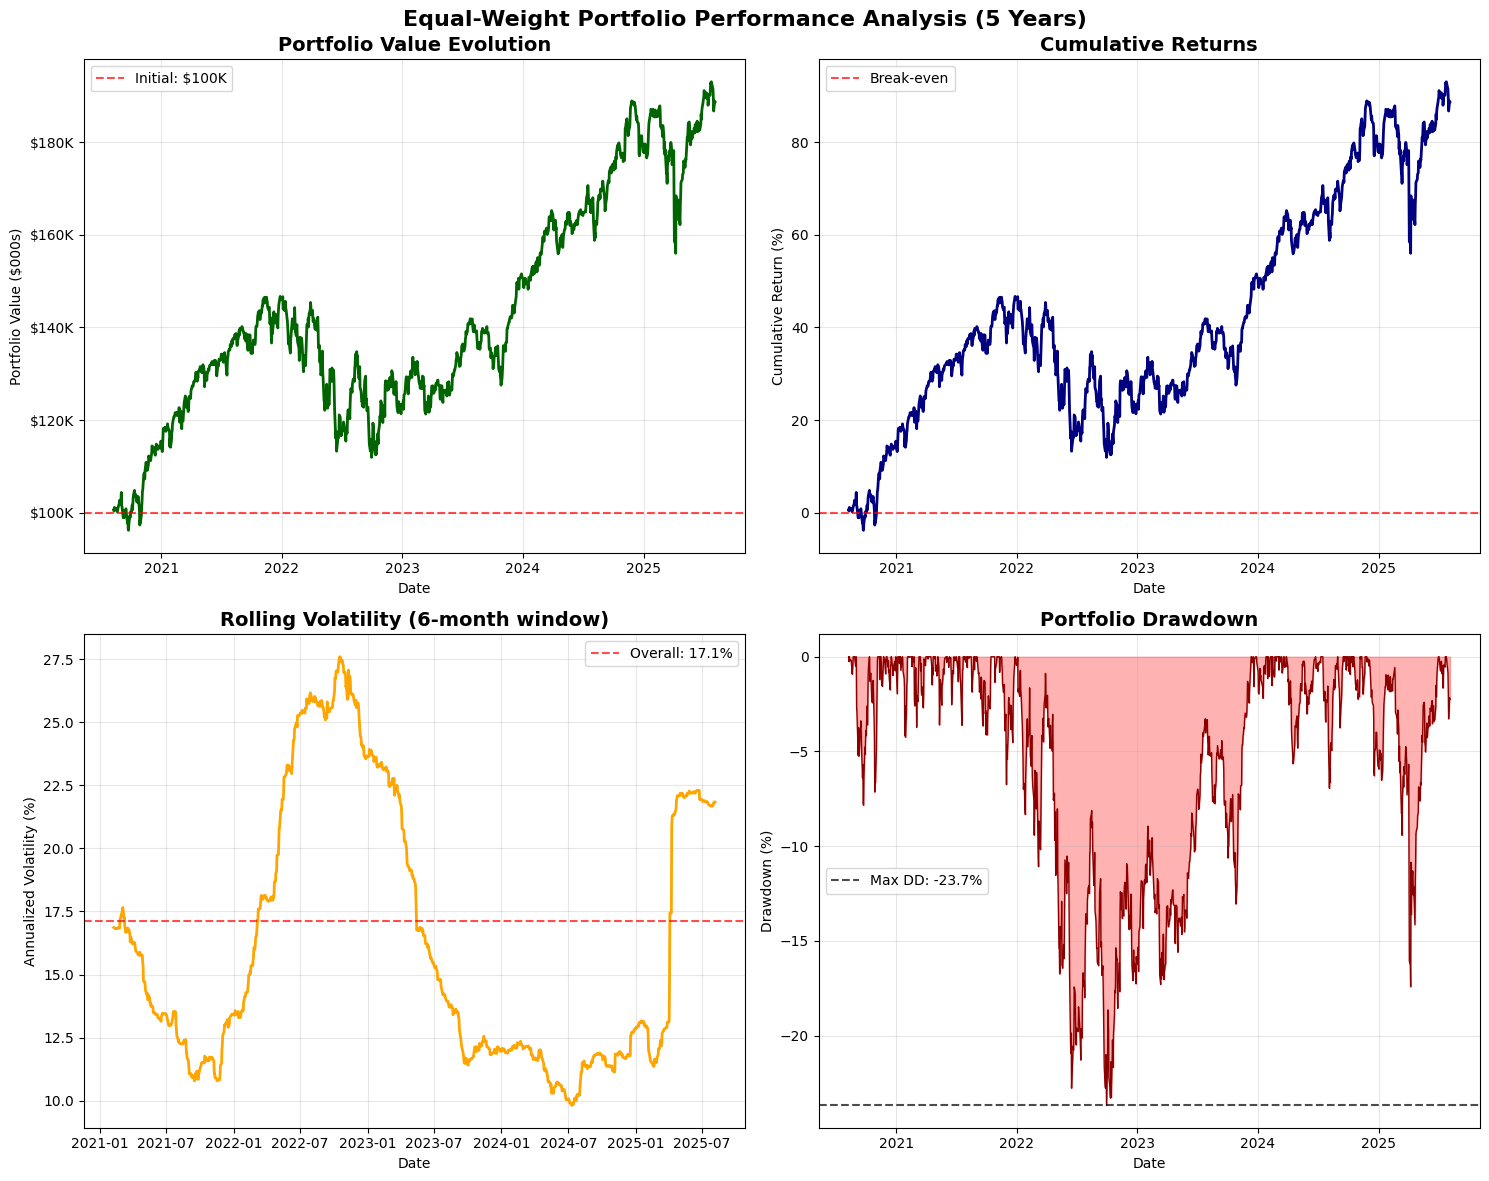

✅ Portfolio performance visualizations created!


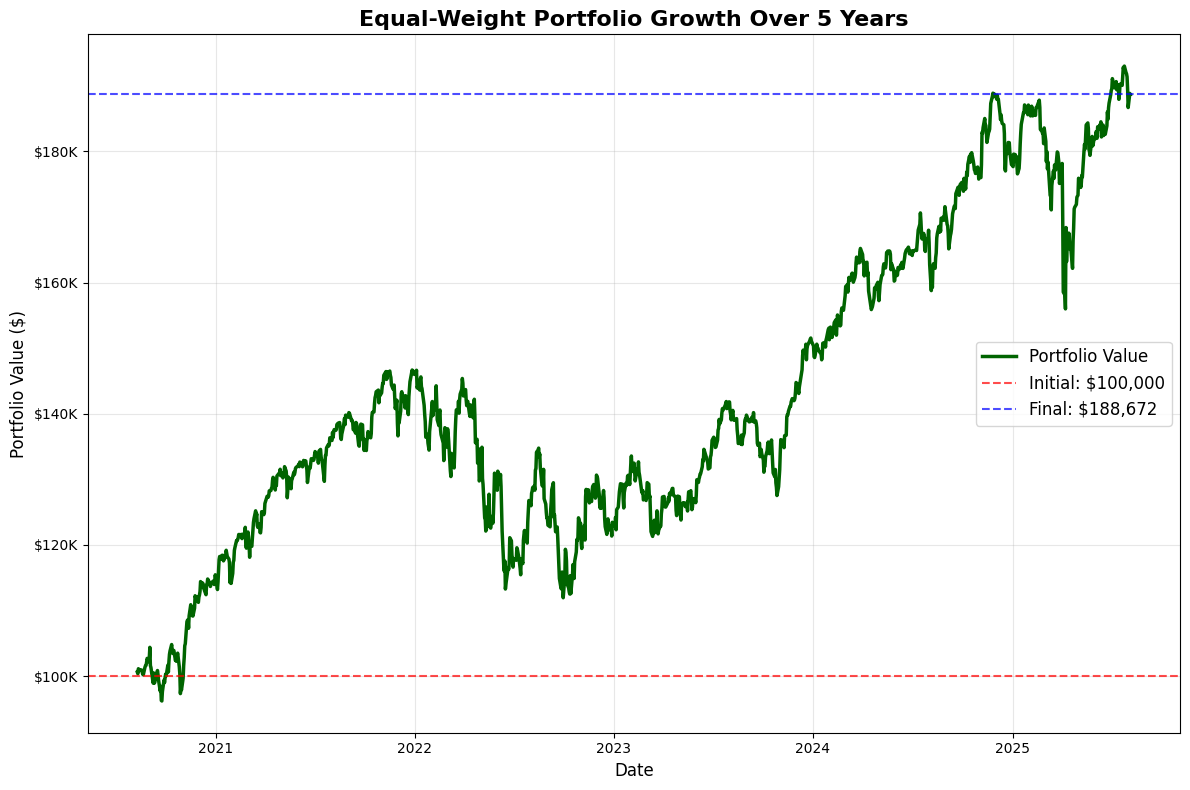

📈 Portfolio growth visualization completed!
💰 Total portfolio appreciation: $88,672
📊 Investment multiplier: 1.89x


In [31]:
# Create comprehensive visualizations
print("📊 Creating portfolio performance visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Equal-Weight Portfolio Performance Analysis (5 Years)', fontsize=16, fontweight='bold')

# Plot 1: Portfolio Value Over Time
axes[0,0].plot(portfolio_value.index, portfolio_value / 1000, 
               linewidth=2, color='darkgreen')
axes[0,0].set_title('Portfolio Value Evolution', fontsize=14, 
                    fontweight='bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Portfolio Value ($000s)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=initial_value/1000, color='red', linestyle='--', 
                  alpha=0.7, label=f'Initial: ${initial_value/1000:.0f}K')
axes[0,0].legend()

# Format y-axis to show values in thousands
axes[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}K'))

# Plot 2: Cumulative Returns
cumulative_returns = (portfolio_value / initial_value - 1) * 100
axes[0,1].plot(portfolio_value.index, cumulative_returns, 
               linewidth=2, color='navy')
axes[0,1].set_title('Cumulative Returns', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Cumulative Return (%)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.7, 
                  label='Break-even')
axes[0,1].legend()

# Plot 3: Rolling Volatility (6-month window)
# 6-month window, annualized
rolling_vol = (portfolio_returns.rolling(window=126).std() * 
               np.sqrt(252) * 100)
axes[1,0].plot(portfolio_value.index, rolling_vol, 
               linewidth=2, color='orange')
axes[1,0].set_title('Rolling Volatility (6-month window)', 
                    fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Annualized Volatility (%)')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axhline(y=annual_volatility*100, color='red', 
                  linestyle='--', alpha=0.7, 
                  label=f'Overall: {annual_volatility*100:.1f}%')
axes[1,0].legend()

# Plot 4: Drawdown Analysis
drawdown_pct = drawdown * 100
axes[1,1].fill_between(portfolio_value.index, drawdown_pct, 0, 
                       alpha=0.3, color='red')
axes[1,1].plot(portfolio_value.index, drawdown_pct, 
               linewidth=1, color='darkred')
axes[1,1].set_title('Portfolio Drawdown', fontsize=14, 
                    fontweight='bold')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Drawdown (%)')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=max_drawdown*100, color='black', 
                  linestyle='--', alpha=0.7, 
                  label=f'Max DD: {max_drawdown*100:.1f}%')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print("✅ Portfolio performance visualizations created!")

# Create separate detailed portfolio value plot
plt.figure(figsize=(12, 8))
plt.plot(portfolio_value.index, portfolio_value, linewidth=2.5, 
         color='darkgreen', label='Portfolio Value')
plt.title('Equal-Weight Portfolio Growth Over 5 Years', 
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add annotations for key milestones
plt.axhline(y=initial_value, color='red', linestyle='--', alpha=0.7, 
            label=f'Initial: ${initial_value:,.0f}')
plt.axhline(y=final_value, color='blue', linestyle='--', alpha=0.7, 
            label=f'Final: ${final_value:,.0f}')

# Format y-axis to show currency
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K')
)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print(f"📈 Portfolio growth visualization completed!")
print(f"💰 Total portfolio appreciation: ${final_value - initial_value:,.0f}")
print(f"📊 Investment multiplier: {final_value/initial_value:.2f}x")

## Deliverables

The following deliverables are produced by this portfolio construction analysis:

### 1. Time Series Data
- **Portfolio Returns**: Daily returns of the equal-weight portfolio
- **Portfolio Values**: Daily portfolio values starting from $100,000
- **Cumulative Returns**: Cumulative performance relative to initial investment
- **Drawdown Analysis**: Maximum drawdown and drawdown periods

### 2. Performance Metrics
- **Total Return**: Overall portfolio performance over the 5-year period
- **CAGR**: Compound Annual Growth Rate
- **Volatility**: Annualized portfolio volatility
- **Sharpe Ratio**: Risk-adjusted return metric
- **Maximum Drawdown**: Worst peak-to-trough decline

### 3. Visualizations
- **Portfolio Growth Chart**: Shows portfolio value evolution over time
- **Cumulative Returns Plot**: Displays percentage gains/losses
- **Rolling Volatility**: 6-month rolling volatility analysis
- **Drawdown Chart**: Visualizes portfolio drawdown periods

### 4. Data Export
The notebook generates exportable data files for further analysis.

In [33]:
# Export deliverables and create summary report
print("📦 Generating deliverables...")

# Create comprehensive results DataFrame
results_df = pd.DataFrame({
    'Date': portfolio_value.index,
    'Portfolio_Value': portfolio_value.values,
    'Portfolio_Return': portfolio_returns.values,
    'Cumulative_Return': ((portfolio_value / initial_value) - 1).values,
    'Drawdown': drawdown.values,
    'Rolling_Max': rolling_max.values
}).set_index('Date')

# Add rolling metrics
results_df['Rolling_Volatility_126d'] = (portfolio_returns.rolling(window=126)
                                         .std() * np.sqrt(252))
results_df['Rolling_Return_126d'] = (portfolio_returns.rolling(window=126)
                                    .mean() * 252)

print(f"✅ Results DataFrame created with shape: {results_df.shape}")
print(f"📊 Columns: {list(results_df.columns)}")

# Export to CSV
try:
    csv_filename = 'equal_weight_portfolio_results.csv'
    results_df.to_csv(csv_filename)
    print(f"💾 Portfolio results exported to: {csv_filename}")
except Exception as e:
    print(f"⚠️ Could not export CSV: {e}")

# Create summary statistics
summary_stats = {
    'Portfolio Metrics': {
        'Initial Value': f"${initial_value:,.2f}",
        'Final Value': f"${final_value:,.2f}",
        'Total Return': f"{total_return:.4f} ({total_return*100:.2f}%)",
        'CAGR': f"{cagr:.4f} ({cagr*100:.2f}%)",
        'Annualized Volatility': f"{annual_volatility:.4f} " +
                                f"({annual_volatility*100:.2f}%)",
        'Sharpe Ratio': f"{sharpe_ratio:.4f}",
        'Maximum Drawdown': f"{max_drawdown:.4f} " +
                           f"({max_drawdown*100:.2f}%)"
    },
    'Portfolio Composition': {
        'Strategy': 'Equal-Weight',
        'Number of Assets': len(weights),
        'Investment Period': f"{days_invested} days ({years_invested:.2f} years)"
    },
    'Risk Metrics': {
        'Best Day Return': f"{portfolio_returns.max():.4f} ({portfolio_returns.max()*100:.2f}%)",
        'Worst Day Return': f"{portfolio_returns.min():.4f} ({portfolio_returns.min()*100:.2f}%)",
        'Positive Days': f"{(portfolio_returns > 0).sum()} ({(portfolio_returns > 0).mean()*100:.1f}%)",
        'Negative Days': f"{(portfolio_returns < 0).sum()} ({(portfolio_returns < 0).mean()*100:.1f}%)"
    }
}

# Display summary report
print("\n" + "="*60)
print("📊 EQUAL-WEIGHT PORTFOLIO CONSTRUCTION SUMMARY REPORT")
print("="*60)

for category, metrics in summary_stats.items():
    print(f"\n🎯 {category}:")
    print("-" * 40)
    for metric, value in metrics.items():
        print(f"  {metric:25}: {value}")

print("\n" + "="*60)
print("✅ Portfolio construction analysis completed successfully!")
print("="*60)

# Quick performance comparison
print(f"\n💡 Key Insights:")
print(f"  • Portfolio grew by {((final_value/initial_value - 1)*100):.1f}% over {years_invested:.1f} years")
print(f"  • Average annual return of {(cagr*100):.1f}% with {(annual_volatility*100):.1f}% volatility")
print(f"  • Risk-adjusted return (Sharpe ratio) of {sharpe_ratio:.2f}")
print(f"  • Maximum loss period resulted in {(max_drawdown*100):.1f}% drawdown")

# Display first and last few portfolio values for verification
print(f"\n📅 Portfolio Value Timeline (First 5 and Last 5 days):")
print("First 5 days:")
for i in range(min(5, len(portfolio_value))):
    date = portfolio_value.index[i]
    value = portfolio_value.iloc[i]
    print(f"  {date.strftime('%Y-%m-%d')}: ${value:,.2f}")

print("...")
print("Last 5 days:")
for i in range(max(0, len(portfolio_value)-5), len(portfolio_value)):
    date = portfolio_value.index[i]
    value = portfolio_value.iloc[i]
    print(f"  {date.strftime('%Y-%m-%d')}: ${value:,.2f}")

📦 Generating deliverables...
✅ Results DataFrame created with shape: (1253, 7)
📊 Columns: ['Portfolio_Value', 'Portfolio_Return', 'Cumulative_Return', 'Drawdown', 'Rolling_Max', 'Rolling_Volatility_126d', 'Rolling_Return_126d']
💾 Portfolio results exported to: equal_weight_portfolio_results.csv

📊 EQUAL-WEIGHT PORTFOLIO CONSTRUCTION SUMMARY REPORT

🎯 Portfolio Metrics:
----------------------------------------
  Initial Value            : $100,000.00
  Final Value              : $188,671.72
  Total Return             : 0.8867 (88.67%)
  CAGR                     : 0.1362 (13.62%)
  Annualized Volatility    : 0.1713 (17.13%)
  Sharpe Ratio             : 0.6247
  Maximum Drawdown         : -0.2367 (-23.67%)

🎯 Portfolio Composition:
----------------------------------------
  Strategy                 : Equal-Weight
  Number of Assets         : 100
  Investment Period        : 1253 days (4.97 years)

🎯 Risk Metrics:
----------------------------------------
  Best Day Return          : 0.0795